# Entrenamiendo de Red Neuronal Convolucional (NVIDIA Model) - Behavioral Cloning

## Navegación Autónoma - MNA
## Equipo 19

- Diego Alvarado Marino - A01795687
- Gabriel Sareñana Labra - A01795507
- Enrique Correa Herrerías - A01332620
- Leonardo Javier Nava Castellanos - A01750595

## **Clonando repositorio con las imagenes**

In [ ]:
!git clone https://github.com/DiegoAlvaradoMarino/equipo19_proyecto_navauto_mna.git

Cloning into 'equipo19_proyecto_navauto_mna'...
remote: Enumerating objects: 19089, done.
remote: Total 19089 (delta 0), reused 0 (delta 0), pack-reused 19089 (from 1)
Receiving objects: 100% (19089/19089), 227.18 MiB | 15.11 MiB/s, done.
Resolving deltas: 100% (570/570), done.
Updating files: 100% (19085/19085), done.


In [ ]:
%cd equipo19_proyecto_navauto_mna/

/content/equipo19_proyecto_navauto_mna


In [ ]:
%ls

images_data/


## **Librerías e instalaciones requeridas**

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, Lambda
from keras.optimizers import Adam
from pathlib import Path

## **Verificando que hay GPU disponible**

In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU detectada: {gpus[0].name}")
else:
    print("No se detectó ninguna GPU.")


GPU detectada: /physical_device:GPU:0


## **Parametros para procesamiento**

In [ ]:
# Parametro de tamaño de imagenes
image_size = (200,66)

## **Cargamos el dataset "image_records.csv"**

In [ ]:
# Cargamos y visualizamos el dataset
images_records_df = pd.read_csv('images_data/images_records.csv')
images_records_df

,Image Name,Steering Angle
0,images\DAM-2025-06-21_23-17-0.png,0.000000
1,images\DAM-2025-06-21_23-17-1.png,0.000000
2,images\DAM-2025-06-21_23-17-2.png,0.000000
3,images\DAM-2025-06-21_23-17-3.png,0.000000
4,images\DAM-2025-06-21_23-17-4.png,0.000000
...,...,...
19079,images\DAM-2025-06-22_00-03-19079.png,0.058807
19080,images\DAM-2025-06-22_00-03-19080.png,0.058807
19081,images\DAM-2025-06-22_00-03-19081.png,0.000000
19082,images\DAM-2025-06-22_00-03-19082.png,0.000000


## **Preprocesamientos de los datos**

### Data Augmentation - Reforzando el peso en las curvas para balanceo

In [ ]:
# Reforzar curvas duplicando ejemplos
curve_threshold = 0.5
times_to_duplicate = 10

left_curves = images_records_df[images_records_df['Steering Angle'] < -curve_threshold]
right_curves = images_records_df[images_records_df['Steering Angle'] > curve_threshold]

# Duplicar curvas
images_records_df = pd.concat(
    [images_records_df] + [left_curves, right_curves] * times_to_duplicate,
    ignore_index=True
)

# Mezclar todo el dataset
images_records_df = images_records_df.sample(frac=1).reset_index(drop=True)

print(f"Dataset expandido con curvas reforzadas: {len(images_records_df)} ejemplos")


Dataset expandido con curvas reforzadas: 25274 ejemplos


### Obtener lista de 'paths' y 'angles'

In [ ]:
# Extraer la columna 'Image Name' del conjunto de datos y almacenarla en 'paths'
base_directory = Path('images_data')
paths = images_records_df['Image Name'].apply(lambda x: base_directory / Path(x.replace("\\", "/")))

# Imprimir el número total de rutas de imágenes
print("Numero de paths encontrados: ", len(paths))

# Extraer la columna 'Steering Angle' del conjunto de datos y almacenarla en 'angles'
angles = images_records_df["Steering Angle"]

print("Ejemplo de paths:", paths[0])

Numero de paths encontrados:  25274
Ejemplo de paths: images_data/images/DAM-2025-06-21_23-43-16169.png


### Visualización de imagenes preprocesadas (recortadas y redimensionadas)

In [ ]:
def crop_image(ruta, size=False, title=''):

    # - Preprocesamiento -
    img = cv2.imread(ruta)  # Cargar la imagen desde la ruta especificada
    img = img[35:,:,:]  # Recortar la parte superior (35 píxeles)
    img = cv2.resize(img, image_size) if size == True else img  # Redimensionar si 'size' está activado
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB

    # - Plot -
    fig = plt.figure(figsize=(4, 5))
    ax1 = fig.add_subplot(111)
    ax1.set_title(title)
    ax1.imshow(RGB_img)  # Mostrar la imagen en formato RGB

images_data/images/DAM-2025-06-22_00-03-18817.png


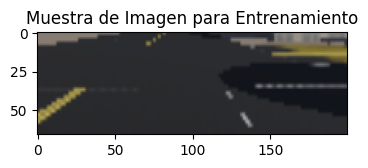

In [ ]:
# Muestreo
index = random.randrange(0, len(paths))
print(paths[index])
crop_image(paths[index], title='Muestra de Imagen para Entrenamiento', size=True)

### Distribución de Ángulos para Entrenamiento

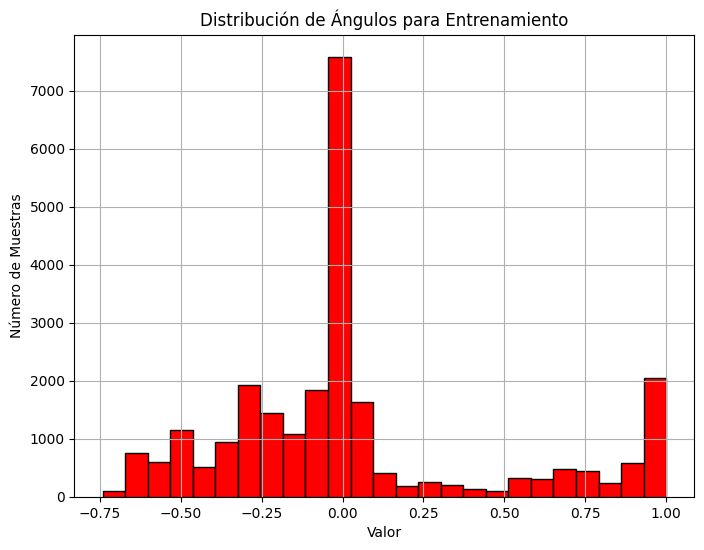

In [ ]:
# Plot de distribución de ángulos
plt.figure(figsize=(8, 6))
plt.hist(angles, bins=25, color='red', edgecolor='black')
plt.title('Distribución de Ángulos para Entrenamiento')
plt.xlabel("Valor")
plt.ylabel("Número de Muestras")
plt.grid(True)
plt.show()

## **Obtención de Datasets de Entrenamiento y Prueba**

In [ ]:
# Función para cargar imágenes en una variable
def upload_dataset(path_list):

    output_list = []
    for path in path_list:
        img = cv2.imread(path) # Cargar la imagen en formato BGR
        img = img[35:,:,:] # Recortar la imagen para eliminar los primeros 35 píxeles
        img = cv2.resize(img, image_size) # Redimensionar la imagen según la variable global image_size
        output_list.append(img) # Añadir la imagen procesada a la lista de salida
    return output_list

# Cargar las imágenes en X_train
X_train = np.array(upload_dataset(paths))

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba, con un tamaño de prueba del 10%
X_train, X_test, y_train, y_test = train_test_split(X_train, angles, test_size=0.1)

print('Shapes del dataset de Entrenamiento: ', X_train.shape, y_train.shape)
print('Shapes del dataset de Prueba:', X_test.shape, y_test.shape)


Shapes del dataset de Entrenamiento:  (22746, 66, 200, 3) (22746,)
Shapes del dataset de Prueba: (2528, 66, 200, 3) (2528,)


In [ ]:
X_train, y_train = shuffle(X_train, y_train) # Revolver los datos
print(X_train.shape[1:]) # Dimensión de las imagenes para uso posterior

(66, 200, 3)


## **Red Neuronal Convolucional (NVIDIA Model)**

___

In [ ]:
# === Construcción del Modelo CNN para Behavioral Cloning ===

# Inicializar el modelo secuencial
model = Sequential()

# --- Preprocesamiento --- # Lambda layer para normalizar las imágenes de entrada a [-1, 1] # Esto ayuda a estabilizar y acelerar el entrenamiento (mejor convergencia)
model.add(Lambda(lambda x: (x / 127.5) - 1.0, input_shape=(66, 200, 3)))

# --- Capas Convolucionales --- # Cada capa extrae características visuales más complejas conforme avanza
model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='relu'))  # Capa 1: 24 filtros, tamaño 5x5, stride 2 para reducir resolución (downsampling) - Para detectar patrones simples como bordes o líneas
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))  # Capa 2: 36 filtros, mismo tamaño y stride - Para aumentar la capacidad para reconocer combinaciones de patrones
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))  # Capa 3: 48 filtros - Esta capa aprende formas más complejas como curvas y estructuras
model.add(Conv2D(64, (3, 3), activation='relu'))  # Capa 4: 64 filtros, tamaño 3x3, sin stride (stride=1 por defecto) - Para mayor detalle en la extracción de características
model.add(Conv2D(64, (3, 3), activation='relu'))  # Capa 5: 64 filtros, igual a la anterior - Esta capa refuerza la capacidad para reconocer objetos y contexto local

# --- Regularización --- # Dropout aleatoriamente "apaga" el 50% de las neuronas durante el entrenamiento # Esto previene el overfitting y mejora la generalización del modelo
model.add(Dropout(0.5))

# --- Capas Densas --- # Aplanar la salida de las capas convolucionales (de 3D a 1D)
model.add(Flatten())

model.add(Dense(100, activation='relu'))  # Capa densa 1: 100 neuronas, activación ReLU - combina características extraídas en patrones más globales
model.add(Dense(50, activation='relu'))  # Capa densa 2: 50 neuronas - sigue refinando la representación de la imagen
model.add(Dense(10, activation='relu'))  # Capa densa 3: 10 neuronas - reduce dimensionalidad antes de la salida final
model.add(Dense(1, activation='tanh'))  # Capa de salida: 1 neurona, activación tanh - produce el ángulo de dirección en el rango [-1, 1]

# --- Compilación del modelo --- # Optimizador: Adam (adaptativo, funciona bien en práctica) # Learning rate: 0.001 (valor común y seguro para empezar) # Función de pérdida: MSE (adecuado para regresión continua como el ángulo de dirección)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# --- Resumen del modelo ---
print(model.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 66, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

None


## **Entrenamiento del Modelo y Validación**

___

In [ ]:
# === Entrenamiento del Modelo con 20 epoch ===
history = model.fit(
    X_train, y_train,              # Datos de entrada (X) y etiquetas (y)
    validation_split=0.2,          # 20% de los datos usados para validación
    epochs=20,                     # Número de pasadas completas sobre el conjunto de entrenamiento
    batch_size=300,                # Número de muestras por lote de actualización
    verbose=1,                     # 1 = muestra barra de progreso durante el entrenamiento
    shuffle=True                   # Mezcla los datos antes de cada época (mejora generalización)
)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - loss: 0.1356 - val_loss: 0.0357
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0351 - val_loss: 0.0287
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0289 - val_loss: 0.0225
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0226 - val_loss: 0.0163
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0194 - val_loss: 0.0145
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0174 - val_loss: 0.0146
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0153 - val_loss: 0.0118
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0133 - val_loss: 0.0105
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0119 - val_loss: 0.0099
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0116 - val_loss: 0.0101
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0103 - val_loss: 0.0086
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0

### Visualizaciónn de las perdidas

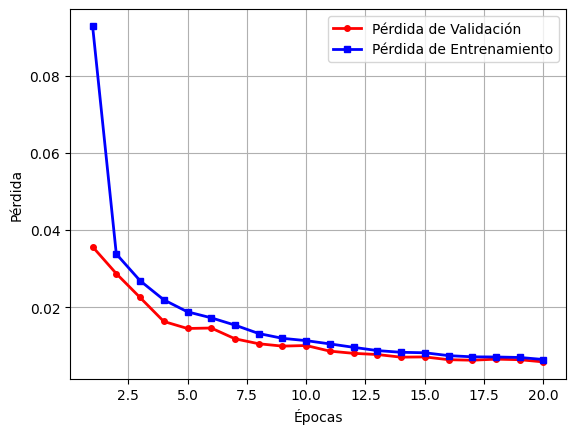

In [ ]:
# Extraer historial de entrenamiento
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

# Graficar pérdida de entrenamiento y validación
line1 = plt.plot(epochs, val_loss_values, label='Pérdida de Validación', color='red')
line2 = plt.plot(epochs, loss_values, label='Pérdida de Entrenamiento', color='blue')

plt.setp(line1, linewidth=2.0, marker='o', markersize=4.0)
plt.setp(line2, linewidth=2.0, marker='s', markersize=4.0)

plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid(True)
plt.legend()
plt.show()


## **Exportarción del Modelo Entrenado**

In [ ]:
# Guardar el modelo entrenado
model.save("../modelos/behavioral_cloning_v5_05_x10_ogcnn.h5")


## **Predicción de prueba del Modelo Entrenado**

In [ ]:
# Cargar el modelo guardado
modelo_entrenado = load_model("../modelos/behavioral_cloning_v5_05_x10_ogcnn.h5", compile=False)


Ruta seleccionada: images_data/images/DAM-2025-06-21_23-43-16175.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicción de la red: -0.5413
Valor real: -0.6235
Error absoluto: 0.0822


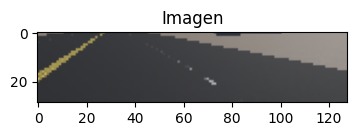

In [ ]:
# Seleccionar aleatoriamente una imagen de prueba
idx = random.randint(0, len(paths) - 1)
ruta = paths[idx]
valor_real = angles[idx]

print(f'Ruta seleccionada: {ruta}')
crop_image(ruta, title='Imagen')

# Preprocesar la imagen para la predicción
entrada = np.array(upload_dataset([ruta]))

# Realizar la predicción con el modelo entrenado
prediccion = modelo_entrenado.predict(entrada)[0][0]

# Mostrar resultados
print(f'Predicción de la red: {prediccion:.4f}')
print(f'Valor real: {valor_real:.4f}')
print(f'Error absoluto: {abs(prediccion - valor_real):.4f}')
